<a href="https://colab.research.google.com/github/OrangBiasa29/Pengolahan-Citra-Digital/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Widad Muhammad Rafi\
NIM: 24/545635/PA/23190

Github: https://github.com/OrangBiasa29/Pengolahan-Citra-Digital

## Segmentation ##
Sebelum kita melakukan morphological processing, kita akan melakukan segmentation terlebih dahulu pada citra kita. Metode segmentation yang akan digunakan di sini adalah Otsu's Method.


--2025-11-07 14:42:45--  https://www.zilliondesigns.com/blog/wp-content/uploads/greyscale.jpg
Resolving www.zilliondesigns.com (www.zilliondesigns.com)... 54.243.177.29
Connecting to www.zilliondesigns.com (www.zilliondesigns.com)|54.243.177.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32823 (32K) [image/jpeg]
Saving to: ‘citra.jpg’

citra.jpg           100%[===================>]  32.05K  --.-KB/s    in 0s      

2025-11-07 14:42:45 (303 MB/s) - ‘citra.jpg’ saved [32823/32823]

Citra sebelum segmentation


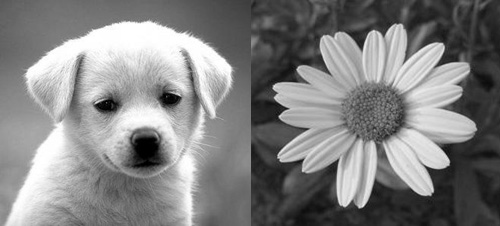


Tresholding optimal Otsu: 141
Citra setelah segmentation dengan Otsu's Method


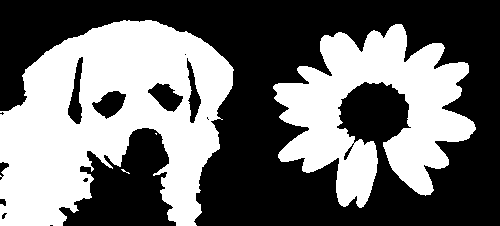

In [9]:
import numpy as np
import cv2 as cv
import os
from google.colab.patches import cv2_imshow

# Unduh Citra
# Updated URL for a valid grayscale image
!wget "https://www.zilliondesigns.com/blog/wp-content/uploads/greyscale.jpg" -O citra.jpg

# Read citra yang diunduh
img = cv.imread('citra.jpg', cv.IMREAD_GRAYSCALE)

print("Citra sebelum segmentation")
cv2_imshow(img)

blur = cv.GaussianBlur(img,(5,5),0)

# Normalisasikan histogram dan cari fungsi distribusi kumulatifnya
hist = cv.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.sum()
Q = hist_norm.cumsum()

bins = np.arange(256)

fn_min = np.inf
thresh = -1

#Otsu's Method
for i in range(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilitas

    q1 = Q[i-1]
    q2 = 1.0 - q1

    if q1 < 1.e-6 or q2 < 1.e-6:
        continue

    b1,b2 = np.hsplit(bins,[i]) # bobot

    # Mencari means dan variance
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q1 # Fix: m2 was used instead of m1 here

    # Minimalisasi
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

print(f"\nTresholding optimal Otsu: {thresh}")

# Terapkan tresholding kita
otsu_img = np.zeros_like(blur)
otsu_img[blur >= thresh] = 255

print("Citra setelah segmentation dengan Otsu's Method")
cv2_imshow(otsu_img)

Pada citra di atas, metode Otsu’s Thresholding berhasil memisahkan objek utama (anjing dan bunga) dari latar belakang. Nilai ambang optimal yang ditemukan adalah 141, yang berarti piksel dengan intensitas di atas 141 dianggap sebagai objek (putih), dan yang di bawah dianggap latar belakang (hitam).

Namun, hasil segmentasi belum sempurna. Terdapat beberapa masalah:

* Lubang pada area objek (noise internal):
Bagian mata, hidung, dan area kepala anjing memiliki lubang kecil yang seharusnya termasuk area objek tetapi justru tersegmentasi sebagai latar belakang.

* Tepi objek tidak halus (ragged edges):
Terlihat beberapa bagian tepi bunga dan telinga anjing memiliki batas yang kasar akibat noise dan variasi intensitas lokal.

* Area background yang masih tertinggal:
Di sekitar objek masih terdapat bintik-bintik putih kecil yang bukan bagian dari objek sebenarnya.


Oleh karena itu kita akan memperbaikinya dengan menggunakan morphological processing berikut:
1. Dilation
2. Closing (dilation + erosion).


 Citra setelah dilation:


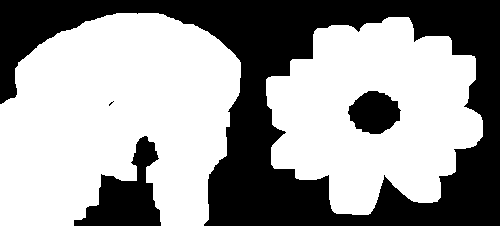


Citra Setelah (dilation + erosion) closing


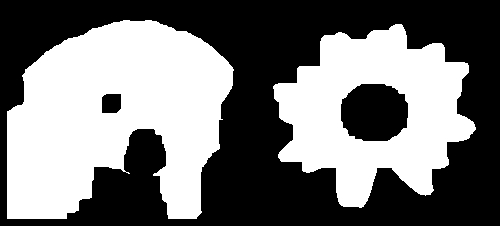

In [10]:
kernel = np.ones((15,15), np.uint8)

# Hitung padding
k_h, k_w = kernel.shape
pad_y = k_h // 2
pad_x = k_w // 2

# Buat citra output untuk dilation
dilation_img = np.zeros_like(otsu_img)

# Tambahkan padding pada hasil segmentasi
padded_dilation_img = np.pad(otsu_img, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)

# Dilation
for y in range(otsu_img.shape[0]):
    for x in range(otsu_img.shape[1]):
        # Dapatkan window
        window = padded_dilation_img[y : y + k_h, x : x + k_w]

        # Terapkan Dilation
        dilation_img[y, x] = np.max(window)

print("\n Citra setelah dilation:")
cv2_imshow(dilation_img)

# Sekarang kita lakukan erosion untuk menyelesaikan closing

# Buat citra output untuk hasil closing
closing_img = np.zeros_like(dilation_img)

# Tambahkan padding ke *hasil dilation*
padded_closing_img = np.pad(dilation_img, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)

# Erosion untuk menyelesaikan closing
for y in range(dilation_img.shape[0]):
    for x in range(dilation_img.shape[1]):
        # Dapatkan window
        window = padded_closing_img[y : y + k_h, x : x + k_w]

        # Terapkan Erosion
        closing_img[y, x] = np.min(window)

print("\nCitra Setelah (dilation + erosion) closing")
cv2_imshow(closing_img)

## Analisis dan Kesimpulan ##
Hasil segmentasi menggunakan metode Otsu pada citra anjing dan bunga berhasil memisahkan objek dari latar belakang dengan cukup baik, namun masih terdapat noise berupa lubang kecil dan tepi yang kasar. Setelah diterapkan proses morfologi, yaitu dilation dan closing (dilation + erosion), bentuk objek menjadi lebih solid dan bersih. Dilation membantu memperluas area objek sehingga bagian yang terputus menyatu, sedangkan closing menutup lubang-lubang kecil tanpa membuat objek tampak membesar secara berlebihan. Secara keseluruhan, kombinasi Otsu dan morphological processing menghasilkan segmentasi yang lebih stabil, jelas.

---